# BOLD monitoring

Download the Jupyter notebook: [BoldMonitoring.ipynb](https://raw.githubusercontent.com/ANNarchy/CNS2023/master/src/notebooks/BoldMonitoring.ipynb){target="_blank"} or run it directly on  [colab.](https://colab.research.google.com/github/ANNarchy/CNS2023/blob/master/src/notebooks/BoldMonitoring.ipynb){target="_blank"}

In [1]:
#!pip install ANNarchy

This notebook demonstrates the usage of the BOLD monitoring extension. It has to be explicitly imported:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ANNarchy import *
from ANNarchy.extensions.bold import *

clear()

ANNarchy 4.7 (4.7.2.5) on darwin (posix).


This script shows a simple example for the application of one of the default models (the *balloon_RN* model) on a simple network. 

There are two important variables in that model: `BOLD` which is the output of the model and `I_CBF` which is the input signal, deonting the mean firing rate of the input populations.

As the BOLD model reflects the change of activity levels in the recorded area, we will implement the following experiment. We record from a population of 100 Izhikevich neurons. After a short period of time we raise the activity level of the population for a fixed time window. For simplicity, we do not use connections between the neurons but simply increase the noise term in the Izhikevich model. This should lead to a noticeable BOLD signal.

### Population

We first create a population of Izhikevich neurons:

In [3]:
pop = Population(100, neuron=Izhikevich)

As we will not have any connections between the neurons, we increase the noise to create some baseline activity:

In [4]:
pop.noise = 5.0

The mean firing rate of the neurons will be used as an input to the BOLD model. This need to be activated explicitly as the computation of this value is quite expensive. 

In our example, the mean firing rate should be computed across a time window of 100 ms. The resulting value will be stored in the `r` attribute of the population and can be easily recorded.

In [5]:
# Compute mean firing rate in Hz on 100ms window
pop.compute_firing_rate(window=100.0)

# Record the mean firing rate
m_spike = Monitor(pop, ['spike'])
m_rate = Monitor(pop, ['r'], start=False)

### BOLD Monitor definition

The BOLD monitor expects a list of populations which we want to record (in our case only `pop`). A BOLD model should be specified, here we take `balloon_RN` which is the default. We then specify the mapping from the population variable that should influence the BOLD signal, in our case the mean firing rate `r`, to the input variable of the BOLD model `I_CBF`. 

The mean firing rate is normalized over a time window of 2000 ms and we record both input and output signals:

In [6]:
m_bold = BoldMonitor(
    
    populations = [pop], # recorded populations
    
    bold_model = balloon_RN(), # BOLD model to use (default is balloon_RN)
    
    mapping = {'I_CBF': 'r'}, # mapping from pop.r to I_CBF
    
    normalize_input = 2000,  # time window to compute baseline.
    
    recorded_variables = ["I_CBF", "BOLD"]  # variables to be recorded
)

Now we can compile and initialize the network:

In [7]:
compile()

Compiling ...  OK 


### Simulation

We first simulate 2 seconds biological time to ensure that the network reaches a stable firing rate:

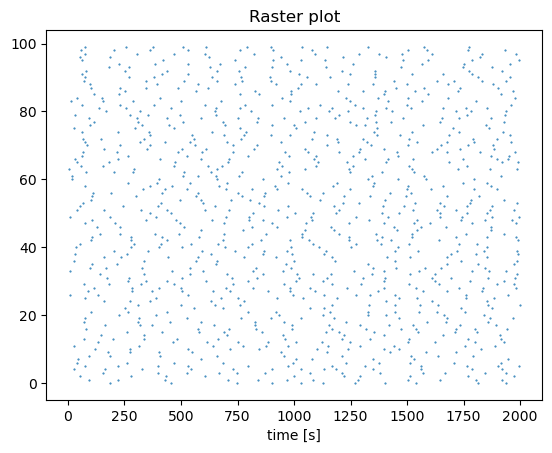

In [8]:
# Ramp up time
simulate(2000)

data = m_spike.get('spike')
t, n = m_spike.raster_plot(data)
m_spike.pause() # stop recording spikes

# Raster plot
plt.figure()
plt.plot(t, n, '.', markersize=1.0)
plt.title("Raster plot")
plt.xlabel("time [s]")
plt.show()

We then enable the recording of all monitors:

In [9]:
m_rate.start()
m_bold.start()

We increase the noise for 5 seconds in a 30s simulation:

In [10]:
# We manipulate the noise for the half of the neurons
simulate(5000)      # 5s with low noise
pop.noise = 7.5
simulate(5000)      # 5s with higher noise
pop.noise = 5.0
simulate(20000)     # 20s with low noise

# Retrieve the recordings
mean_fr = np.mean(m_rate.get("r"), axis=1)
input_data = m_bold.get("I_CBF")
bold_data = m_bold.get("BOLD")

### Evaluation

We can now plot:

* the mean firing rate in the input population.
* the recorded activity `I` which serves as an input to the BOLD model.
* the resulting BOLD signal.

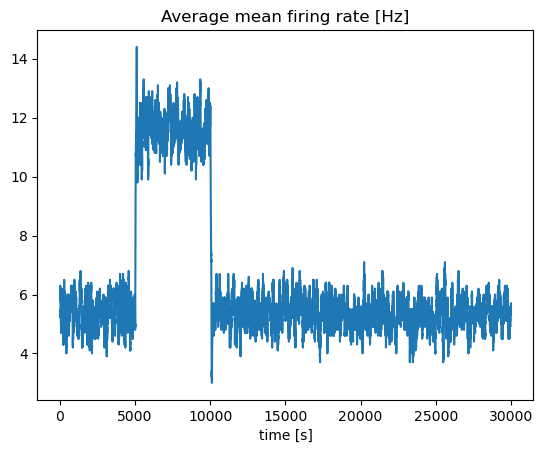

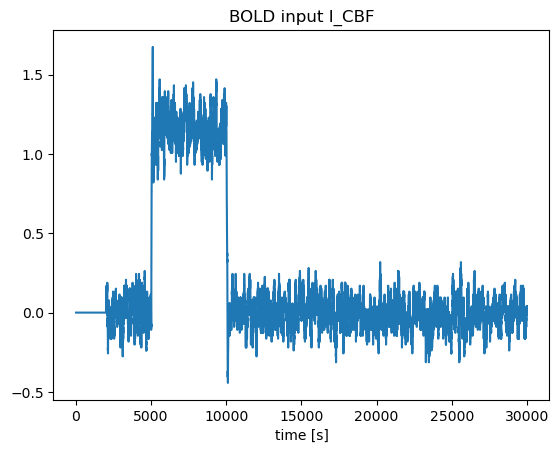

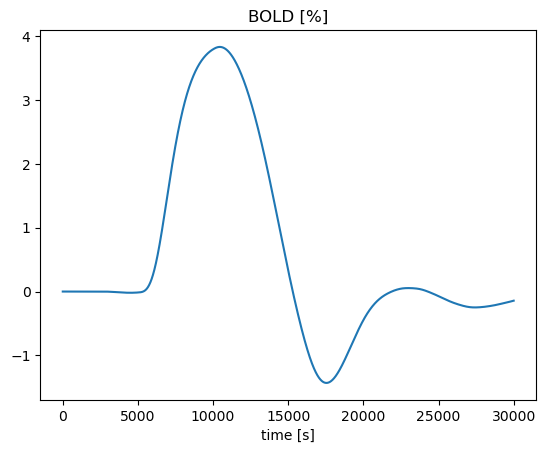

In [11]:
# Firing rate
plt.figure()
plt.plot(mean_fr)
plt.title("Average mean firing rate [Hz]")
plt.xlabel("time [s]")

# BOLD input signal
plt.figure()
plt.plot(input_data)
plt.title("BOLD input I_CBF")
plt.xlabel("time [s]")

# BOLD output signal
plt.figure()
plt.plot(bold_data*100.0)
plt.title("BOLD [%]")
plt.xlabel("time [s]")

plt.show()

**Experiments:**

1. Play around with the amplitude and duration of the stimulation to see the impact on the BOLD signal (do not hesitate to simulate for longer).